# Bayesian Blocks

#### author : 

#### created :

#### Table Of Contents
1. [Introduction](#1.-Introduction:)

2. [Objective](#2.-Objective:)

3. [Method](#3.-Method:)



### 1. Introduction:
Bayesian Blocks is a time-domain algorithm for detecting localized structures (bursts), revealing pulse shapes, and generally characterizing intensity variations. The input is raw counting data, in any of three forms: time-tagged events(TTE), binned counts, or time-to-spill data. The output is the most probable segmentation of the observation into time intervals during which the amplitude is perceptibly constant, i.e. has no statistically significant variations. The idea is not that the times series of events is deemed to have this discontinuous, piecewise constant form, rather that such an approximate and generic model is often useful. The analysis is based on Bayesian statistics.


### 2. Objective:

The method was first used to address the problem of detecting and characterizing local variability in time series and other forms of sequential data in astronomical data. The main objective of this method is to design a histogram that fits to the data well in a way that it distinguishes between observational errors and statistical significance. 

## 3. Method:

______________________________________________________________________________________________






### 3.1. Blockwise Model :

The range of independent variables(e.g., time) are divided into subintervals(called blocks) which are normally unequal in size. The dependent variables(e.g., intensity) are usually constant within errors in a single block. In more complicated models one might use linear or exponential functions to show the dependency of the variables within blocks, in this paper, however, it is not needed to increase the complexity when the data is well-presented with the constant model. 

Defining the times ending one block and starting the next as change points, the model of the whole observation interval contains these parameters:


$1. N_{cp}:$ The number of change points. 


$2. t_{k}^{cp}:$ The change-point starting block K (and ending block (k-1))

$3. X_{k}:$ The signal amplitude in block K.


$ K = 1, 2, 3, ....., N_{cp} + 1$


* it is important to mention that the first datum is always considered the first change-point; therefore, it is not a free parameter.


In [1]:
install.packages("svMisc")
library(svMisc)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [2]:
#Juilia's data:
#producing some fake data to see the result for it:
data = c(rnorm(1000, mean = 0), rcauchy(1000, 5))
data = data[data> -5 & data<10]

typeof(data)

[1] "double"

In [4]:
#George's data

data <- read.table("./spectrum.dat")
data = data$V1

In [5]:
#defining the fitness function:
logf <- function(N_k, T_k){
    return(N_k * log(N_k/T_k))
}

In [36]:
#The fitness function = Cash#

BB <- function(x) {
    
    #for atomic data vectors(1D):
    if (class(x) == 'numeric') {
        x_sorted = sort(x)
        x_unique <- c(x_sorted[1])
        x_weight <- c(1)
        for(i in 2:length(x_sorted)) {
            #adding weight if it is repeated:
            if(x_sorted[i] == x_sorted[i-1]) {
            x_weight[length(x_weight)] <- x_weight[length(x_weight)] + 1
            }
            else {
            x_unique <- c(x_unique, x_sorted[i])
            x_weight <- c(x_weight, 1)
            }
        }    
    }#---------------------------------------------------------- 
           
    #For histogram data:        
    else if (class(x) == 'histogram') {
        eg <- data$breaks
        x_unique <- c(eg[1],data$mids,eg[length(eg)])
        x_weight <- c(1,data$counts,1)
    }        
    else {
        stop('The data type is not supported! Please input numeric vectors or histograms')
        
    }#------------------------------------------------------------ 
    
                
     #Final number of data points:       
    N = length(x_unique) 
    
    

    
    

    
    #defining a prior dis function:
    logp <- function(prior) {
        if(prior == 'uniform') {
            return(0)
        }
        else if(prior == 'gamma') {
            #gamma = as.numeric(readline('input the parameter gamma: '))
            gamma = 0.01
            return(-log(gamma))
        }
        else if(prior == 'p0') {
            #p0 = as.numeric(readline('input the parameter p0: '))
            p0 = 0.01
            return( log(73.53 * p0 * N^(-0.478)) - 4)
            
        }
        else {
            stop('No Prior Distribution input!')
        }
        
    }
        
    x <- x_unique
    
    #input one of these:
    #1.uniform           2.gamma              3.p0
    prior_input = readline('Please input the type of prior distribution: ')
        
    #calculating the prior:
    ncp_prior = logp(prior = prior_input)
         
        
    #array of all possible edges:
    edges <- c(x[1], 0.5*(x[1:(length(x)-1)] + x[2:length(x)]), x[length(x)])
    
   
    best = c()
    last = c()
        
        
    F <- function(r, k){
    return(logf(sum(x_weight[r:k]), edges[k+1] - edges[r]) + ncp_prior)
    } 
        
    for (k in 1:N){
    A <- c()
    for (r in 1:k){
        A <- c(A, F(r, k)+ if(r==1) 0 else best[r-1])
    }
    last <- c(last, which.max(A))
    best <- c(best, max(A, na.rm=TRUE))
    progress(k, N, progress.bar=TRUE)
    if (k == N) message("Done!")
    }
    
               
    
               
    cp <- c()
    i <- N + 1
    while(i!=0){
        cp <- c(cp, i)
        i = (if(i == 1) 0 else last[i - 1])
    }

    y <- c()
    for (j in cp[length(cp):-1:1]){
        y <- c(y, edges[j])
    }
    return(y)
   
    
}

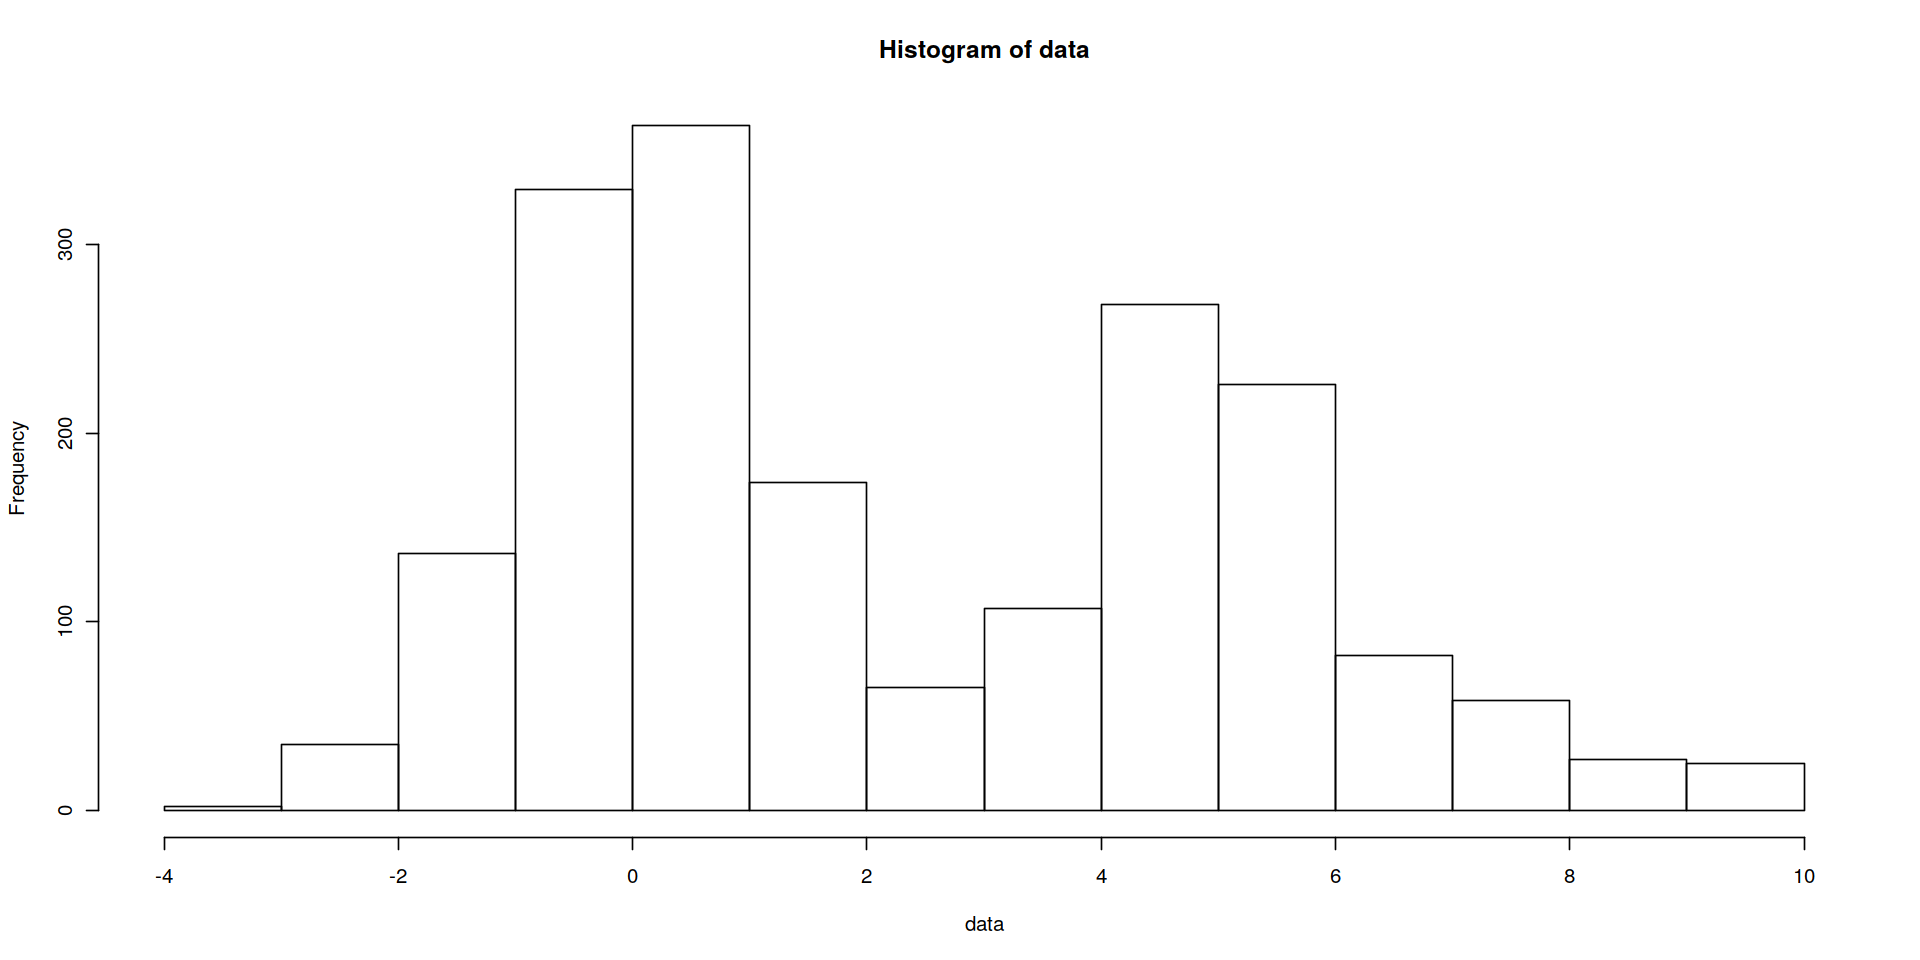

In [56]:
hist(data)

In [ ]:
breaks = BB(data)

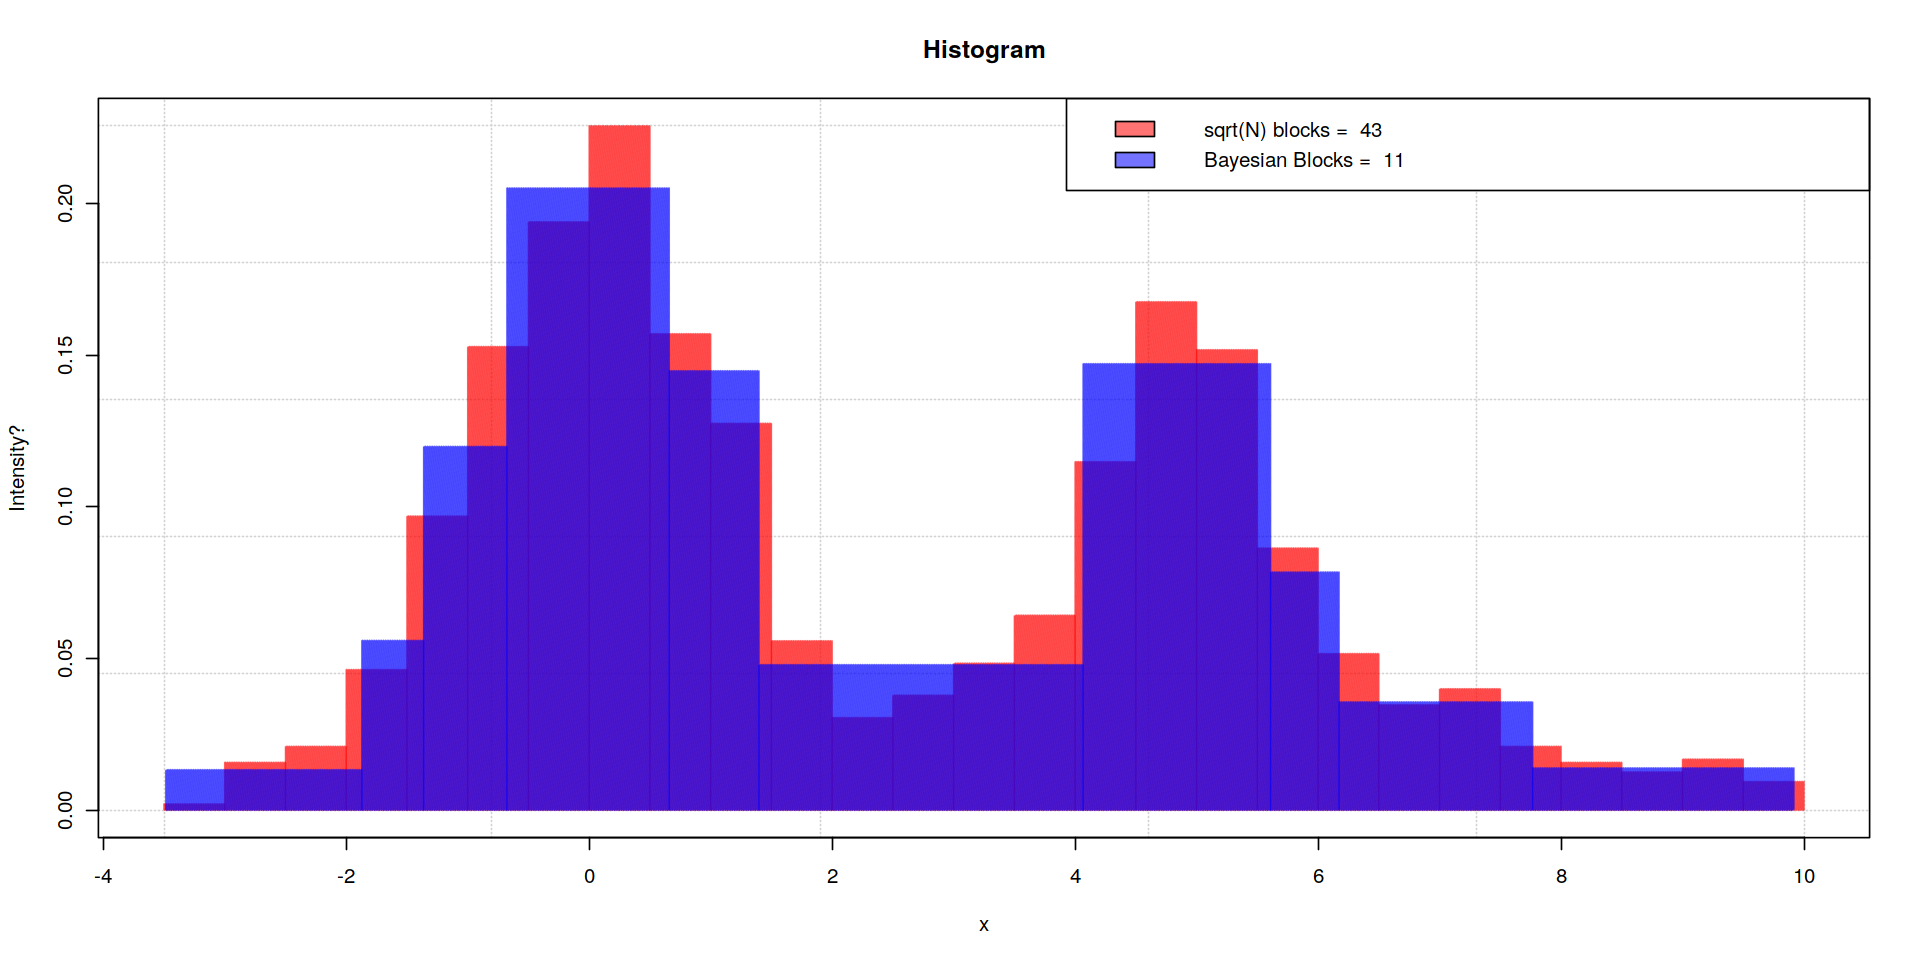

In [55]:
N <- length(data)

col1 = scales::alpha(2,.55)
col2 = scales::alpha(4,.55)

# sqrt(N)
hist(data,breaks=sqrt(N),freq=FALSE,col=col1,border=F, panel.first=grid(),density=200,
     xlab='x',ylab='Intensity?',main=('Histogram'))
# Bayesian Blocks
hist(data,breaks=breaks,density=200, col=col2,border=F,add=T)

text_legend <- c(sprintf("sqrt(N) blocks = %3i",floor(sqrt(N))), sprintf("Bayesian Blocks = %3i",length(breaks)))

legend("topright", 
       legend=text_legend,
       fill=c(col1, col2),
       text.width = strwidth(text_legend)[2]/2)
box()
